### Detecção de Objeto

O Objetivo nesse notebook é fazer detecção de objetos em imagens, vamos focar na deteção de um único objeto, ou seja, vamos escolher uma imagem e o algorítmo vai nos retornar o objeto em destaque da imagem.

Para isso, vamos usar em conjunto duas ferramentas:

__1 - Selective Search da biblioteca OpenCV__

__2 - Rede neural VGG19 do Keras__

A ideia é usar o Selective Search para pegar vários retangulos de destaque na imagem que escolheremos, e usaremos as novas imagens geradas por cada um desses retangulos na VGG19 que nos retornará uma probabilidade de determinado objeto está em cada uma das imagens geradas.

Depois pegaremos as imagens onde tivermos uma maior probabilidade, e depois ver qual objeto se repete mais nas predições.

Esse objeto será nossa predição final.

In [2]:
# importando as bibliotecas que precisaremos inicialmente

import matplotlib.pyplot as plt
import numpy as np
import cv2

Vamos escolhar uma imagem que contém um cachorro, e vamos criar nosso algoritmo para ver como ele se sai:

In [2]:
image = cv2.imread('dog.2653.jpg')

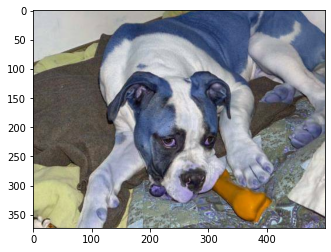

In [3]:
plt.imshow(image)

In [4]:
image

array([[[192, 195, 200],
        [192, 195, 200],
        [193, 196, 201],
        ...,
        [199, 199, 199],
        [198, 198, 198],
        [197, 197, 197]],

       [[194, 197, 202],
        [194, 197, 202],
        [195, 198, 203],
        ...,
        [200, 200, 200],
        [199, 199, 199],
        [197, 197, 197]],

       [[195, 198, 203],
        [196, 199, 204],
        [196, 199, 204],
        ...,
        [200, 200, 200],
        [199, 199, 199],
        [198, 198, 198]],

       ...,

       [[190, 186, 175],
        [193, 189, 178],
        [205, 199, 188],
        ...,
        [102, 108, 115],
        [126, 132, 139],
        [127, 133, 140]],

       [[184, 180, 169],
        [186, 182, 171],
        [197, 191, 180],
        ...,
        [ 87,  93, 100],
        [114, 120, 127],
        [124, 130, 137]],

       [[179, 175, 164],
        [180, 176, 165],
        [190, 184, 173],
        ...,
        [ 70,  76,  83],
        [ 94, 100, 107],
        [106, 112, 119]]

In [5]:
# aqui usaremos o Selective Search para a segmentação, usaremos o método 'fast', mas ao final, criaremos uma função onde
# podemos escolher também o método 'Quality".

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
retangulos = ss.process()

In [6]:
# vendo a quantidade de retangulos criadas com o processo.

retangulos.shape

(1567, 4)

Cada retângulo gerado pelo selective search tem altura e comprimento diferentes, se apenas recortarmos a imagem de acordo com eles, não poderemos aplicar diretamente na VGG19, pois a VGG 19 aceita imagens com formato de 224x224 pixels.

Precisamos então fazer um redimensionamento nas imagens novas, vamos fazer isso com o primeiro retângulo no código abaixo:

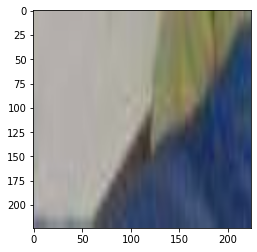

In [7]:
# redimensionando e plotando a imagem gerada com o primeiro retângulo do selective search.

x,y,w,h = retangulos[0]

image1 = image[y:y+h, x:x+w]

image1 = cv2.resize(image1, dsize=(224, 224))

plt.imshow(image1)

In [8]:
# conferindo a dimensão da imagem

image1.shape

(224, 224, 3)

O próximo passo é juntar todas as imagens em um array novo, onde cada linha desse array, é uma imagem colorida de 224x224 pixels, em termos de matrizes, cada linha desse array vai ser um elemento de tamanho (224,224,3).


In [9]:
retangulos_imagem = image1.reshape(1,224,224,3)

for i in range(1,retangulos.shape[0]):
  x,y,w,h = retangulos[i]
  imagem2 = image[y:y+h, x:x+w]
  imagem2 = cv2.resize(imagem2, dsize=(224, 224))
  imagem2 = imagem2.reshape(1,224,224,3)
  retangulos_imagem = np.concatenate((retangulos_imagem, imagem2))



Vamos conferir o tamanho do nosso novo array, que deve ser de $(1567,224,224,3)$

In [10]:
 retangulos_imagem.shape

(1567, 224, 224, 3)

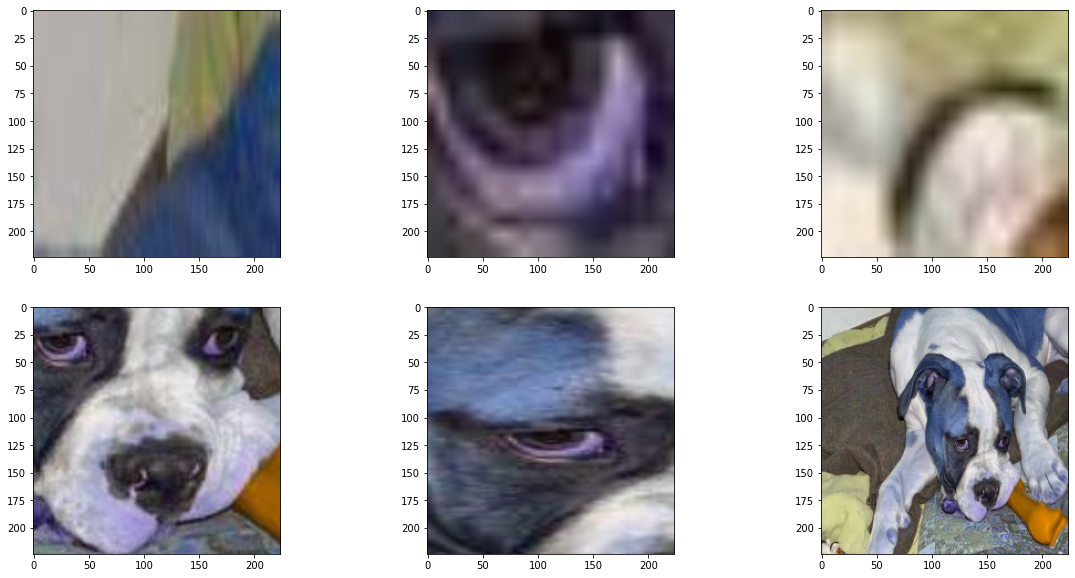

In [11]:
# conferindo algumas imagens do nosso array:

plt.figure(figsize = [20,10])

plt.subplot(2,3,1)
plt.imshow(retangulos_imagem[0])

plt.subplot(2,3,2)
plt.imshow(retangulos_imagem[68])

plt.subplot(2,3,3)
plt.imshow(retangulos_imagem[589])

plt.subplot(2,3,4)
plt.imshow(retangulos_imagem[862])

plt.subplot(2,3,5)
plt.imshow(retangulos_imagem[1300])

plt.subplot(2,3,6)
plt.imshow(retangulos_imagem[1566])

plt.show()

Agora que estamos com as imagens geradas pelo selective search redimensionadas e todas organizadas em um novo array, vamos importar o VGG19 para fazer nossa aplicação.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import decode_predictions
from keras.applications.vgg19 import VGG19

Antes de implementar as imagens na VGG19, precisamos fazer um pré-processamento nelas, faremos isso em todas as imagens do array criado acima, e criaremos um novo array, que no caso, as imagens já estarão redimensionadas, pré-processadas e organizadas em um único lugar.

Faremos isso no código abaixo.

In [13]:
retangulos_imagem1 = retangulos_imagem[0].reshape(1,224,224,3)

retangulos_imagem1 = preprocess_input(retangulos_imagem1)

for i in range(1,retangulos_imagem.shape[0]):
  imagem2 = retangulos_imagem[i].reshape((1,224,224,3))
  imagem2 = preprocess_input(imagem2)
  retangulos_imagem1 = np.concatenate((retangulos_imagem1, imagem2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


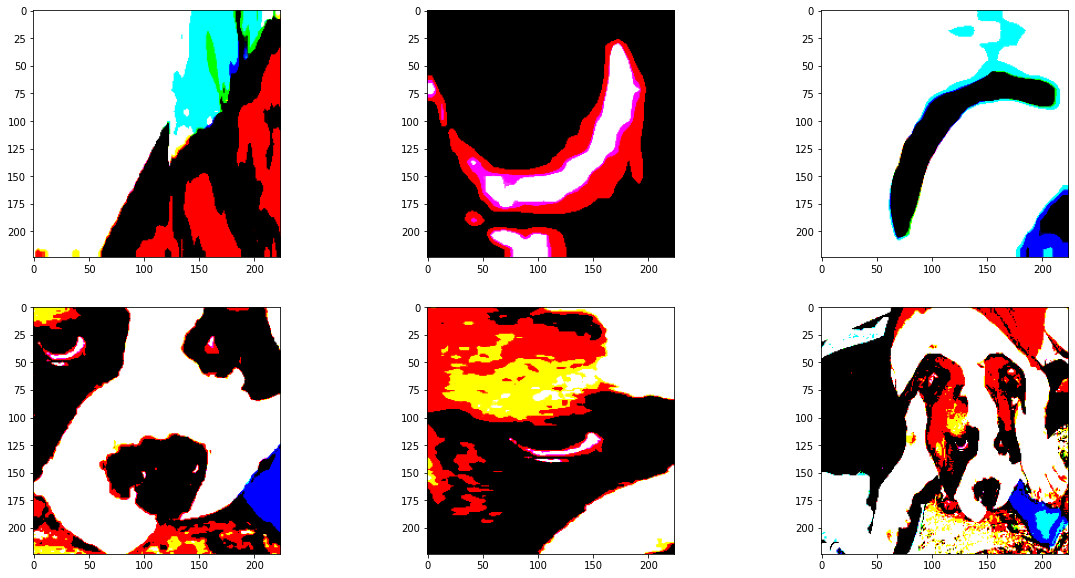

In [14]:
# conferindo algumas imagens do nosso novo array:

plt.figure(figsize = [20,10])

plt.subplot(2,3,1)
plt.imshow(retangulos_imagem1[0])

plt.subplot(2,3,2)
plt.imshow(retangulos_imagem1[68])

plt.subplot(2,3,3)
plt.imshow(retangulos_imagem1[589])

plt.subplot(2,3,4)
plt.imshow(retangulos_imagem1[862])

plt.subplot(2,3,5)
plt.imshow(retangulos_imagem1[1300])

plt.subplot(2,3,6)
plt.imshow(retangulos_imagem1[1566])

plt.show()

In [15]:
# conferindo mais uma vez o tamanho

retangulos_imagem1.shape

(1567, 224, 224, 3)

### Fazendo as predições

Agora que fizemos todo o tratamento necessário para usar a VGG19, vamos fazer as predições em cada um das imagens geradas pelo selective search.

In [4]:
modelo = VGG19()

In [17]:
# fazendo as predições e tomando a predição com maior probabilidade em cada uma das imagens.

ypred = modelo.predict(retangulos_imagem1)
ypredd = decode_predictions(ypred, top = 1)

49152/35363 [=========================================] - 0s 0us/step


Lembrando que temos 1567 imagens, cada uma teve uma previsão feita pelo VGG19, vamos então fazer um filtro, vamos pegar aquelas imagens no qual tiveram uma previsão maior do que ou igual a 70% de ser algum objeto.

In [18]:
lista70mais = []
imagens70mais = []

for i in range(len(ypredd)):
  if ypredd[i][0][2]>=0.7:
    lista70mais.append(ypredd[i])
    imagens70mais.append(ypredd.index(ypredd[i]))

Vamos dar uma rápida olhada nessa lista e ver qual o seu tamanho.

In [19]:
lista70mais, len(lista70mais)

([[('n01873310', 'platypus', 0.76926416)],
  [('n01873310', 'platypus', 0.7831546)],
  [('n01855032', 'red-breasted_merganser', 0.70009476)],
  [('n02606052', 'rock_beauty', 0.7747641)],
  [('n02108089', 'boxer', 0.73133695)],
  [('n01855032', 'red-breasted_merganser', 0.7230722)],
  [('n02093428', 'American_Staffordshire_terrier', 0.70046663)],
  [('n04525038', 'velvet', 0.78296876)],
  [('n02606052', 'rock_beauty', 0.784564)],
  [('n02108089', 'boxer', 0.72143096)],
  [('n02108089', 'boxer', 0.72610515)],
  [('n02108089', 'boxer', 0.8408655)],
  [('n01873310', 'platypus', 0.8527007)],
  [('n02108089', 'boxer', 0.74728084)],
  [('n02093428', 'American_Staffordshire_terrier', 0.7253855)],
  [('n02606052', 'rock_beauty', 0.7245274)],
  [('n01855032', 'red-breasted_merganser', 0.9162625)],
  [('n01818515', 'macaw', 0.8729971)],
  [('n02606052', 'rock_beauty', 0.7463738)],
  [('n02109047', 'Great_Dane', 0.8908006)],
  [('n02109047', 'Great_Dane', 0.8650847)],
  [('n02093428', 'American_St

Reduzimos de 1567 para 57 imagens, vamos plotar então essas imagens.

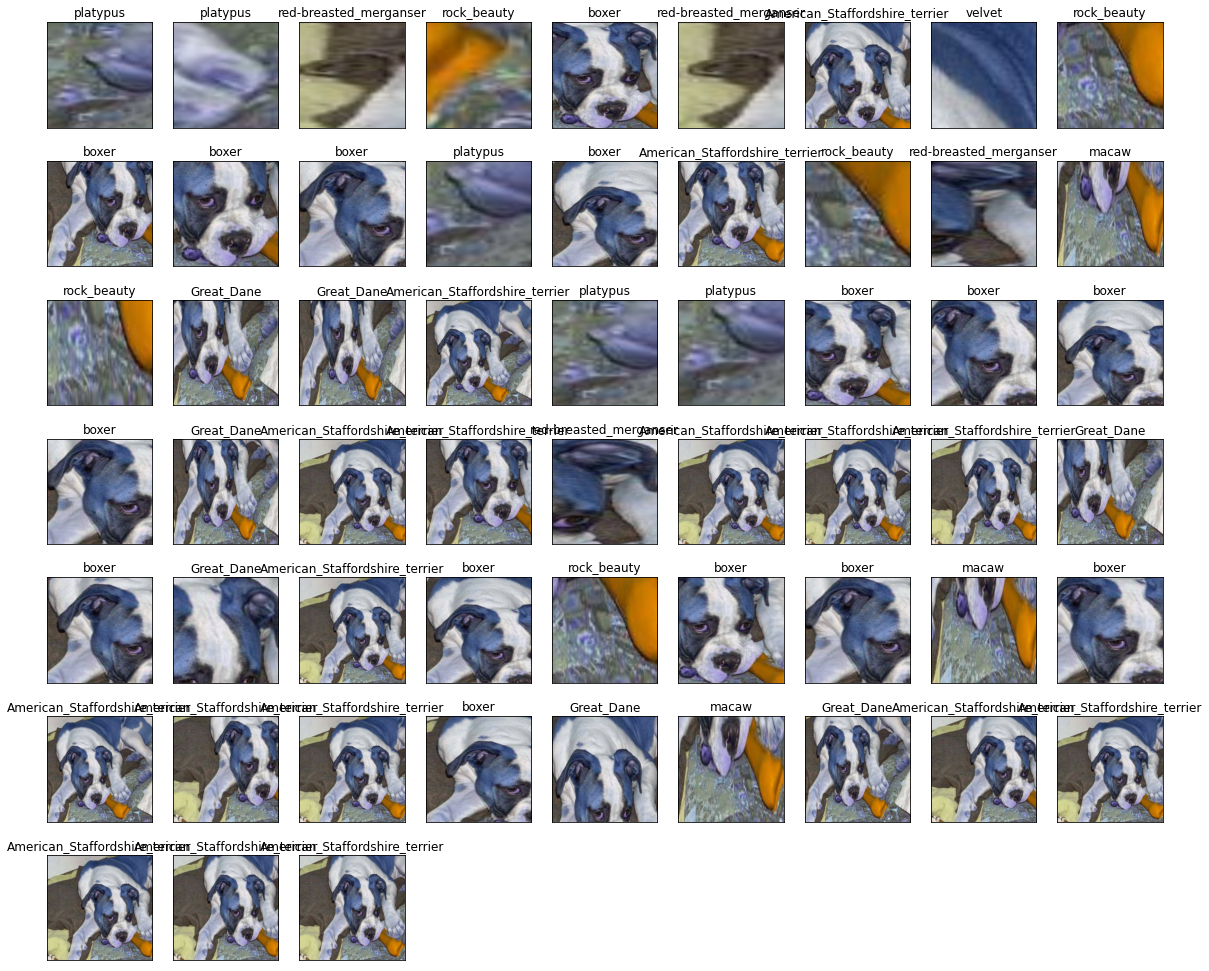

In [20]:
plt.figure(figsize=[20,20])
for i in range(len(imagens70mais)):
    x = retangulos_imagem[imagens70mais[i]]
    plt.subplot(8,9,i+1)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    plt.title(lista70mais[i][0][1])
plt.show()

Conseguimos observar que o algoritmo já detectou que temos um cachorro na imagem, mas parece que ele tem uma dúvida sobre ser um Boxer ou um American Staffordshire Terrier.

Como escolheremos a previsão final?

Vamos criar uma lista com todas as previsões acima de 70% e depois escolheremos aquela que mais se repete.

In [21]:
preds = []
for i in range(len(lista70mais)):
  preds.append(lista70mais[i][0][1])


preds1 = [[preds[0], preds.count(preds[0])]]
for i in range(len(preds)):
  if preds.count(preds[i]) > preds1[0][1]:
    preds1 = [[preds[i], preds.count(preds[i])]]

print('O objeto detectado em nosso algoritmo é : ', preds1[0][0])

O objeto detectado em nosso algoritmo é :  American_Staffordshire_terrier


Temos então nossa predição final. Se procurarmos imagens no google, veremos que as duas raças são bem parecidas em fotos, eu não conseguiria diferenciar uma de outra.

Claro que poderiamos melhorar nosso algoritmo, como por exemplo, pra ele retornas 3 possibilidades com uma média de porcentagem ou algo do tipo, porém para fins de exemplo, conseguimos atingir nosso objetivo.

Agora iremos juntar todos esses passos feitos em uma única função, onde colocaremos como parâmetro a imagem que queremos detectar o objeto e a qualdade que queremos usar no Selective Search.

In [6]:
from keras.preprocessing.image import load_img

In [7]:
def detectaObjeto(imagem, qualidade):
  image = cv2.imread(imagem)
  image0 = load_img(imagem)
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  if qualidade == 'fast':
    ss.switchToSelectiveSearchFast()
  else:
    ss.switchToSelectiveSearchQuality()

  retangulos = ss.process()
  x,y,w,h = retangulos[0]
  image1 = image[y:y+h, x:x+w]
  image1 = cv2.resize(image1, dsize=(224, 224))
  retangulos_imagem = image1.reshape(1,224,224,3)

  for i in range(1,retangulos.shape[0]):
    x,y,w,h = retangulos[i]
    imagem2 = image[y:y+h, x:x+w]
    imagem2 = cv2.resize(imagem2, dsize=(224, 224))
    imagem2 = imagem2.reshape(1,224,224,3)
    retangulos_imagem = np.concatenate((retangulos_imagem, imagem2))

  retangulos_imagem1 = retangulos_imagem[0].reshape(1,224,224,3)
  retangulos_imagem1 = preprocess_input(retangulos_imagem1)

  for i in range(1,retangulos_imagem.shape[0]):
    imagem2 = retangulos_imagem[i].reshape((1,224,224,3))
    imagem2 = preprocess_input(imagem2)
    retangulos_imagem1 = np.concatenate((retangulos_imagem1, imagem2))
  
  modelo = VGG19()
  ypred = modelo.predict(retangulos_imagem1)
  ypredd = decode_predictions(ypred, top = 1)

  lista70mais = []
  imagens70mais = []

  for i in range(len(ypredd)):
    if ypredd[i][0][2]>=0.7:
      lista70mais.append(ypredd[i])
      imagens70mais.append(ypredd.index(ypredd[i]))
  preds = []
  for i in range(len(lista70mais)):
    preds.append(lista70mais[i][0][1])
  
  preds1 = [[preds[0], preds.count(preds[0])]]
  for i in range(len(preds)):
    if preds.count(preds[i]) > preds1[0][1]:
      preds1 = [[preds[i], preds.count(preds[i])]]

  plt.imshow(image0)
  plt.title(preds1[0][0])

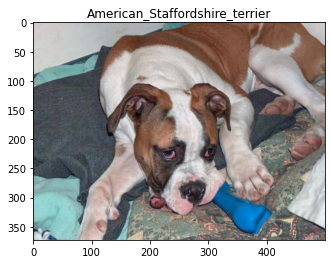

In [25]:
detectaObjeto('dog.2653.jpg', 'fast')

Vamos pegar mais um exemplo, dessa vez, uma imagem de um gato, e ver como nossa função se sai:

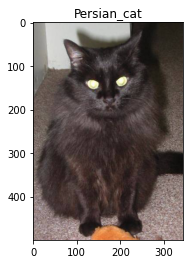

In [27]:
detectaObjeto('cat.55.jpg','fast')

Para finalizar, vamos pegar uma imagem de um molusco e ver como a função se sai:

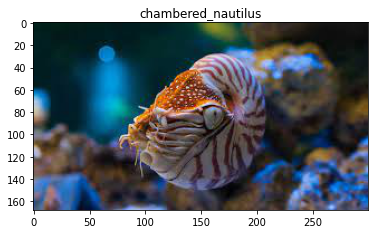

In [30]:
detectaObjeto('naut.jpg','fast')

Tanto no Persa quando no molusco, as predições foram corretas sem nenhuma suspeita de erro.

Finalizamos aqui nosso notebook, com essa rapida introdução à detecção de objetos com uso de Selective search e do VGG19 trabalhando em conjunto.